In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os
from pathlib import Path

np.random.seed(42)
tf.random.set_seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt

# Basic RNNs

## Generate the Dataset

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0,1,n_steps)
    series = 0.5*np.sin((time-offsets1) * (freq1 * 10 +10))
    series += 0.2 * np.sin((time-offsets2) *(freq2 *20+20))
    series += 0.1 * (np.random.rand(batch_size, n_steps)-0.5)
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps=50
series=generate_time_series(10000, n_steps+1)
X_train, y_train = series[:7000,:n_steps], series[:7000,-1]
X_valid, y_valid = series[7000:9000,:n_steps], series[7000:9000,-1]
X_test, y_test = series[9000:,:n_steps], series[9000:,-1]


In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

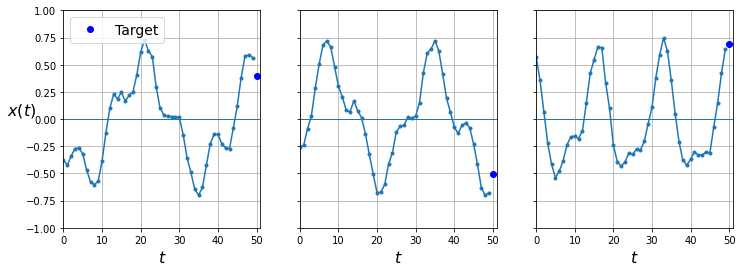

In [5]:
def plot_series(series, y=None, y_pred=None, x_label ="$t$", y_label = "$x(t)$", legend = True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label = "Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label = "Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize =16)
    if y_label:
        plt.ylabel(y_label, fontsize = 16, rotation=0)
    plt.hlines(0,0,100, linewidth =1)
    plt.axis([0, n_steps+1, -1,1])
    if legend and (y or y_pred):
        plt.legend(fontsize= 14, loc = "upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey =True, figsize=(12,4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label = ("$x(t)$" if col==0 else None), 
                legend = (col==0))


## Computing Some Baselines

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

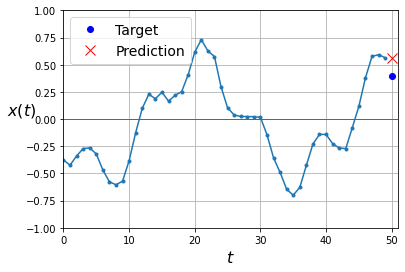

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0,0])

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([keras.layers.Flatten(input_shape=[50,1]), 
                                 keras.layers.Dense(1)])
model.compile(loss="mse", optimizer='adam')
history = model.fit(X_train,y_train, epochs=20,
                   validation_data= (X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 1ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 936us/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 930us/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 940us/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 949us/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 938us/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 911us/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 916us/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 930us/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 940us/step - loss: 0.0061 

In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 605us/step - loss: 0.0042


0.004168087150901556

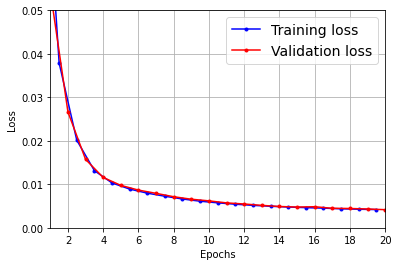

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss))+0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss))+1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1,20, 0,0.05])
    plt.legend(fontsize= 14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    
plot_learning_curves(history.history["loss"], history.history["val_loss"])

63/63 [==============================] - 0s 505us/step


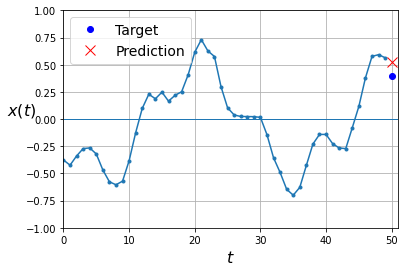

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0,:,0], y_valid[0,0], y_pred[0,0])

## Using a Simple RNN

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape= [None, 1])
])

optimizer= keras.optimizers.Adam(learning_rate= 0.005)
model.compile(loss="mse", optimizer = optimizer)
history = model.fit(X_train, y_train, epochs =20,validation_data= (X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0116 - val_lo

In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0109


0.010881561785936356

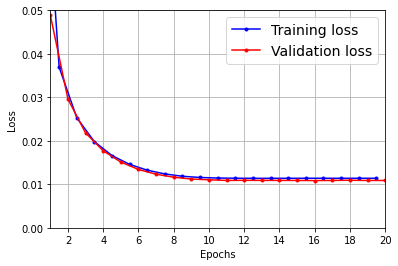

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])

63/63 [==============================] - 0s 6ms/step


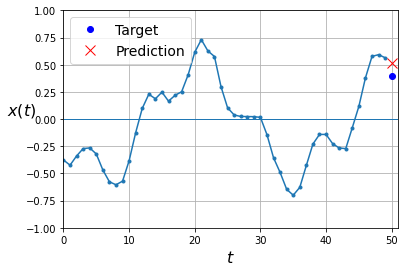

In [15]:
y_pred=model.predict(X_valid)
plot_series(X_valid[0,:,0], y_valid[0,0], y_pred[0,0])

## Deep RNNs

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape= [None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer = 'adam')
history = model.fit(X_train, y_train, epochs =20,validation_data= (X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 11s 48ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 10s 48ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 11s 48ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 10s 48ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 10s 47ms/step - loss: 0.003

In [17]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 10ms/step - loss: 0.0029


0.0029105599969625473

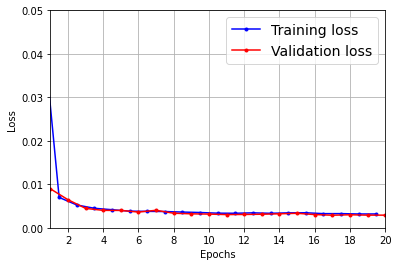

In [18]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])

63/63 [==============================] - 1s 8ms/step


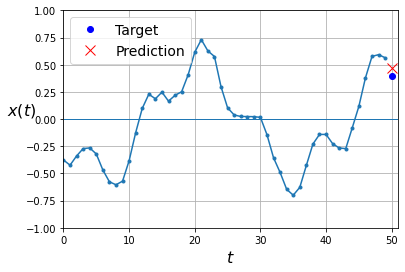

In [19]:
y_pred=model.predict(X_valid)
plot_series(X_valid[0,:,0], y_valid[0,0], y_pred[0,0])

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape= [None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer = 'adam')
history = model.fit(X_train, y_train, epochs =20,validation_data= (X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0030 - val_lo

In [21]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 11ms/step - loss: 0.0026


0.0026236246339976788

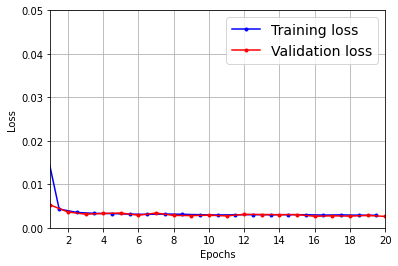

In [22]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])

63/63 [==============================] - 1s 8ms/step


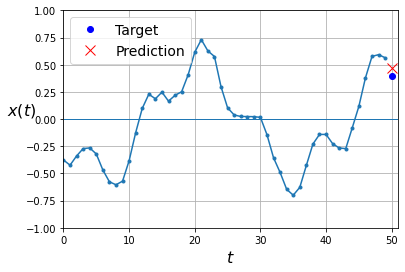

In [23]:
y_pred=model.predict(X_valid)
plot_series(X_valid[0,:,0], y_valid[0,0], y_pred[0,0])

## forecasting Several Steps Ahead

In [24]:
np.random.seed(43)

series = generate_time_series(1, n_steps +10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X= X_new
for step_ahead in range(10):
    y_pred_one= model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X= np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 15ms/step


In [25]:
Y_pred.shape

(1, 10, 1)

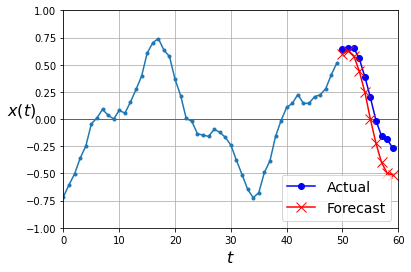

In [26]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps =X.shape[1]
    ahead=Y.shape[1]
    plot_series(X[0,:,0])
    plt.plot(np.arange(n_steps, n_steps+ahead), Y[0,:,0], "bo-", label = "Actual")
    plt.plot(np.arange(n_steps,n_steps+ahead), Y_pred[0,:,0], "rx-", markersize=10, label = "Forecast")
    plt.axis([0, n_steps+ahead, -1,1])
    plt.legend(fontsize= 14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)


In [27]:
np.random.seed(42)

n_steps= 50
series = generate_time_series(10000, n_steps +10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:,0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:,0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:,0]

In [28]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X= np.concatenate([X, y_pred_one], axis =1)
    
Y_pred =X[:, n_steps:, 0]

63/63 [==============================] - 1s 9ms/step


In [29]:
Y_pred.shape

(2000, 10)

In [30]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.027510807

In [31]:
Y_naive_pred= np.tile(X_valid[:, -1],10)
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25697407

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, input_shape= [50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer = 'adam')
history = model.fit(X_train, y_train, epochs =20,validation_data= (X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0863 - val_loss: 0.0600
Epoch 2/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0572 - val_loss: 0.0532
Epoch 3/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0502 - val_loss: 0.0528
Epoch 4/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0462 - val_loss: 0.0442
Epoch 5/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0433 - val_loss: 0.0410
Epoch 6/20
219/219 [==============================] - 3s 11ms/step - loss: 0.0403 - val_loss: 0.0392
Epoch 7/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0384 - val_loss: 0.0370
Epoch 8/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0366 - val_loss: 0.0341
Epoch 9/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0339 - val_loss: 0.0327
Epoch 10/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0332 - val_lo

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape= [None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer = 'adam')
history = model.fit(X_train, y_train, epochs =20,validation_data= (X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0895 - val_loss: 0.0585
Epoch 2/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0501 - val_loss: 0.0396
Epoch 3/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0367 - val_loss: 0.0345
Epoch 4/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0320 - val_loss: 0.0289
Epoch 5/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0291 - val_loss: 0.0261
Epoch 6/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0274 - val_loss: 0.0275
Epoch 7/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0260 - val_loss: 0.0269
Epoch 8/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0257 - val_loss: 0.0239
Epoch 9/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0242 - val_loss: 0.0234
Epoch 10/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0239 - val_lo

In [34]:
np.random.seed(43)

series = generate_time_series(1, 50 +10)
X_new, Y_new = series[:, :50,:], series[:, -10:,:]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 [==============================] - 0s 126ms/step


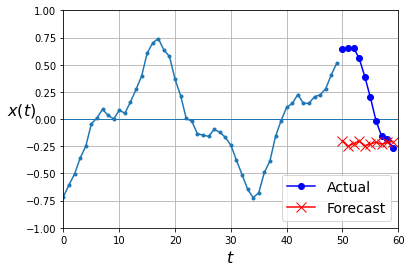

In [35]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)

In [36]:
np.random.seed(42)

n_steps= 50
series = generate_time_series(10000, n_steps +10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y= np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10+1):
    Y[..., step_ahead -1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]


In [37]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape= [None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])
model.compile(loss="mse", optimizer = keras.optimizers.Adam(learning_rate= 0.01), metrics =[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs =20,validation_data= (X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0353 - val_last_time_step_mse: 0.0245
Epoch 3/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0323 - last_time_step_mse: 0.0211 - val_loss: 0.0379 - val_last_time_step_mse: 0.0312
Epoch 4/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0297 - last_time_step_mse: 0.0185 - val_loss: 0.0279 - val_last_time_step_mse: 0.0159
Epoch 5/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0274 - last_time_step_mse: 0.0154 - val_loss: 0.0276 - val_last_time_step_mse: 0.0184
Epoch 6/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0250 - last_time_step_mse: 0.0126 - val_loss: 0.0241 - val_last_time_step_mse: 0.0114
Epoch 7/20
219/219 [==

In [39]:
np.random.seed(43)

series = generate_time_series(1, 50 +10)
X_new, Y_new = series[:, :50,:], series[:, 50:,:]
Y_pred = model.predict(X_new)[:,-1][..., np.newaxis]

1/1 [==============================] - 0s 126ms/step


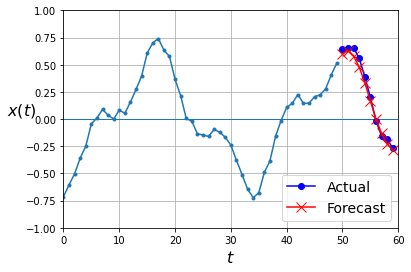

In [40]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)

# Deep RNN with Batch Norm

In [41]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape= [None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer = 'adam', metrics =[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs =20,validation_data= (X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 8s 30ms/step - loss: 0.1929 - last_time_step_mse: 0.1902 - val_loss: 0.0877 - val_last_time_step_mse: 0.0832
Epoch 2/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0537 - last_time_step_mse: 0.0449 - val_loss: 0.0549 - val_last_time_step_mse: 0.0462
Epoch 3/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0471 - last_time_step_mse: 0.0375 - val_loss: 0.0451 - val_last_time_step_mse: 0.0358
Epoch 4/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0437 - last_time_step_mse: 0.0337 - val_loss: 0.0418 - val_last_time_step_mse: 0.0314
Epoch 5/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0409 - last_time_step_mse: 0.0306 - val_loss: 0.0391 - val_last_time_step_mse: 0.0287
Epoch 6/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0385 - last_time_step_mse: 0.0275 - val_loss: 0.0379 - val_last_time_step_mse: 0.0273
Epoch 7/20
219/219 [==

# Deep RNN with Layer Norm

In [42]:
from tensorflow.keras.layers import LayerNormalization

In [43]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation='tanh', **kwargs):
        super().__init__ (**kwargs)
        self.state_size=units
        self.output_size=units
        self.simple_rnn_cell=keras.layers.SimpleRNNCell(units,activation=None)
        self.layer_norm = LayerNormalization()
        self.activation=keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size =tf.shape(inputs)[0]
            dtype=inputs.dtype
        return [tf.zeros([batch_size,self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states=self.simple_rnn_cell(inputs, states)
        norm_outputs=self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [44]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape= [None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer = 'adam', metrics =[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs =20,validation_data= (X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 16s 65ms/step - loss: 0.1594 - last_time_step_mse: 0.1552 - val_loss: 0.0730 - val_last_time_step_mse: 0.0662
Epoch 2/20
219/219 [==============================] - 14s 64ms/step - loss: 0.0638 - last_time_step_mse: 0.0545 - val_loss: 0.0571 - val_last_time_step_mse: 0.0463
Epoch 3/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0537 - last_time_step_mse: 0.0428 - val_loss: 0.0502 - val_last_time_step_mse: 0.0378
Epoch 4/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0472 - last_time_step_mse: 0.0350 - val_loss: 0.0448 - val_last_time_step_mse: 0.0332
Epoch 5/20
219/219 [==============================] - 14s 64ms/step - loss: 0.0424 - last_time_step_mse: 0.0295 - val_loss: 0.0410 - val_last_time_step_mse: 0.0289
Epoch 6/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0392 - last_time_step_mse: 0.0260 - val_loss: 0.0371 - val_last_time_step_mse: 0.0226
Epoch 7/20
219/2

# Creating a Custom RNN Class

In [45]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences= False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state= getattr(self.cell, "get_initial_state",self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return [tf.zeros([batch_size, self.cell.state_size], dtype = inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape= tf.shape(inputs)
        batch_size = shape[0]
        n_steps=shape[1]
        sequences = tf.TensorArray(inputs.dtype, size = (n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size], dtype = inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences =sequences.write(step, outputs)
        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1,0,2])
        else:
            return outputs

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True, 
          input_shape =[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history=model.fit(X_train, Y_train, epochs=20, validation_data =(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 15s 66ms/step - loss: 0.1593 - last_time_step_mse: 0.1547 - val_loss: 0.0741 - val_last_time_step_mse: 0.0682
Epoch 2/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0650 - last_time_step_mse: 0.0558 - val_loss: 0.0577 - val_last_time_step_mse: 0.0463
Epoch 3/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0537 - last_time_step_mse: 0.0420 - val_loss: 0.0497 - val_last_time_step_mse: 0.0377
Epoch 4/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0476 - last_time_step_mse: 0.0356 - val_loss: 0.0456 - val_last_time_step_mse: 0.0347
Epoch 5/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0433 - last_time_step_mse: 0.0311 - val_loss: 0.0414 - val_last_time_step_mse: 0.0285
Epoch 6/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0396 - last_time_step_mse: 0.0272 - val_loss: 0.0372 - val_last_time_step_mse: 0.0237
Epoch 7/20
219/2

# LSTMs

In [48]:
np.random.seed(42)
tf.random.set_seed(42)

model= keras.models.Sequential([keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
                               keras.layers.LSTM(20, return_sequences=True),
                               keras.layers.TimeDistributed(keras.layers.Dense(10))
                               ])
model.compile(loss="mse", optimizer = 'adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs= 20, validation_data =(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 5ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0551 - val_last_time_step_mse: 0.0382
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0474 - last_time_step_mse: 0.0274 - val_loss: 0.0420 - val_last_time_step_mse: 0.0214
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0387 - last_time_step_mse: 0.0178 - val_loss: 0.0364 - val_last_time_step_mse: 0.0156
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0348 - last_time_step_mse: 0.0149 - val_loss: 0.0332 - val_last_time_step_mse: 0.0131
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0324 - last_time_step_mse: 0.0133 - val_loss: 0.0313 - val_last_time_step_mse: 0.0122
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0308 - last_time_step_mse: 0.0123 - val_loss: 0.0297 - val_last_time_step_mse: 0.0113
Epoch 7/20
219/219 [========

In [49]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.02375539019703865, 0.008563954383134842]

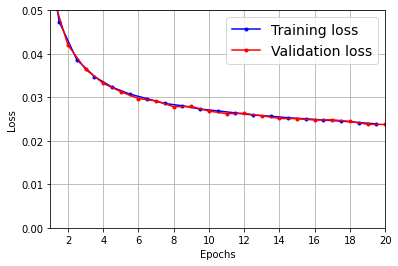

In [50]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [51]:
np.random.seed(43)

series = generate_time_series(1, 50+10)
X_new, Y_new =series[:,:50,:], series[:, 50:,:]
Y_pred= model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 385ms/step


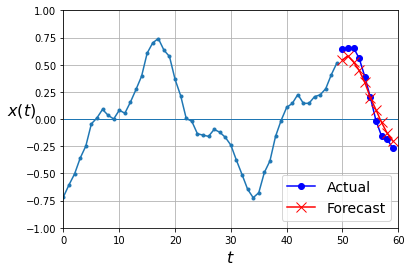

In [52]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRUs

In [53]:
np.random.seed(42)
tf.random.set_seed(42)

model= keras.models.Sequential([keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
                               keras.layers.GRU(20, return_sequences=True),
                               keras.layers.TimeDistributed(keras.layers.Dense(10))
                               ])
model.compile(loss="mse", optimizer = 'adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs= 20, validation_data =(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 5ms/step - loss: 0.0738 - last_time_step_mse: 0.0655 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0417 - last_time_step_mse: 0.0301 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0368 - last_time_step_mse: 0.0243 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0326 - last_time_step_mse: 0.0180 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0306 - last_time_step_mse: 0.0155 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [========

In [54]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


[0.023785525932908058, 0.01026284322142601]

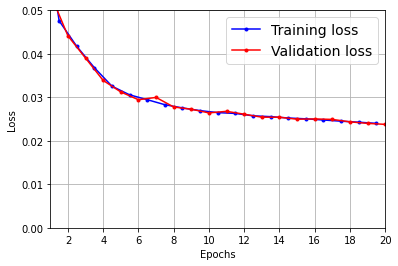

In [55]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [56]:
np.random.seed(43)

series = generate_time_series(1, 50+10)
X_new, Y_new =series[:,:50,:], series[:, 50:,:]
Y_pred= model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 342ms/step


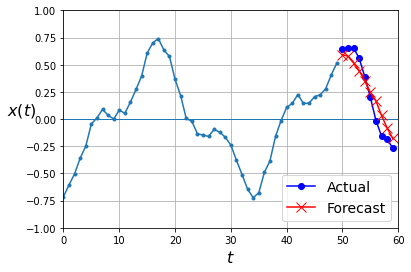

In [57]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Using One-Dimensional Convolutional Layers to Process Sequences
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|  
        |-----1-----|     |-----4-----|   ...      |-----22----|  
  |-----0----|      |-----3-----|     |---...|-----21----|  
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49  
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50  
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49  
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59

In [59]:
np.random.seed(42)
tf.random.set_seed(42)

model= keras.models.Sequential([
    keras.layers.Conv1D(filters =20, kernel_size=4, strides=2, padding = 'valid', input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer = 'adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:,3::2], epochs= 20, validation_data =(X_valid, Y_valid[:,3::2]))

Epoch 1/20
219/219 [==============================] - 4s 5ms/step - loss: 0.0681 - last_time_step_mse: 0.0601 - val_loss: 0.0477 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0414 - last_time_step_mse: 0.0340 - val_loss: 0.0367 - val_last_time_step_mse: 0.0285
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0338 - last_time_step_mse: 0.0257 - val_loss: 0.0307 - val_last_time_step_mse: 0.0218
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0282 - last_time_step_mse: 0.0184 - val_loss: 0.0259 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0249 - last_time_step_mse: 0.0143 - val_loss: 0.0246 - val_last_time_step_mse: 0.0141
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0234 - last_time_step_mse: 0.0125 - val_loss: 0.0227 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [========

# WaveNet

In [61]:
np.random.seed(42)
tf.random.set_seed(42)

model= keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None,1]))
for rate in (1,2,4,8) *2:
    model.add(keras.layers.Conv1D(filters =20, kernel_size=2,
                                  padding = 'causal', activation = 'relu', dilation_rate = rate))
model.add(keras.layers.Conv1D(filters =10, kernel_size=1))
          
model.compile(loss="mse", optimizer = 'adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs= 20, validation_data =(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 5ms/step - loss: 0.0668 - last_time_step_mse: 0.0543 - val_loss: 0.0365 - val_last_time_step_mse: 0.0231
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0323 - last_time_step_mse: 0.0192 - val_loss: 0.0294 - val_last_time_step_mse: 0.0166
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0283 - last_time_step_mse: 0.0156 - val_loss: 0.0269 - val_last_time_step_mse: 0.0145
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0261 - last_time_step_mse: 0.0136 - val_loss: 0.0254 - val_last_time_step_mse: 0.0130
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0248 - last_time_step_mse: 0.0124 - val_loss: 0.0244 - val_last_time_step_mse: 0.0122
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0240 - last_time_step_mse: 0.0117 - val_loss: 0.0233 - val_last_time_step_mse: 0.0108
Epoch 7/20
219/219 [========

In [62]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation ="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation=keras.activations.get(activation)
    def call(self, inputs):
        n_filters= inputs.shape[-1] //2
        linear_output = self.activation(inputs[..., :n_filters])
        gate= keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [63]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size= 2, padding="causal", 
                           dilation_rate=dilation_rate)(inputs)
    z= GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [64]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block =3
n_blocks =1
n_filters=32
n_outputs=10

inputs = keras.layers.Input(shape=[None, 1])
z= keras.layers.Conv1D(n_filters, kernel_size=2, padding = 'causal')(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)

z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z=keras.layers.Conv1D(n_filters, kernel_size=1, activation = 'relu')(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs= [Y_proba])

In [65]:
model.compile(loss="mse", optimizer = 'adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs= 2, validation_data =(X_valid, Y_valid))

Epoch 1/2
219/219 [==============================] - 2s 5ms/step - loss: 0.1300 - last_time_step_mse: 0.1260 - val_loss: 0.1229 - val_last_time_step_mse: 0.1199
Epoch 2/2
219/219 [==============================] - 1s 4ms/step - loss: 0.1222 - last_time_step_mse: 0.1178 - val_loss: 0.1217 - val_last_time_step_mse: 0.1189
